In [23]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

from xgboost import XGBClassifier
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')
sns.set()

## Read Data

In [24]:
data_file = Path.cwd().parent / 'data' / 'harvard' / 'race_gender_parent.tsv'

df = pd.read_csv(data_file, sep='\t')
df = df.astype({
    'id': 'int',
    'callback': 'int',
    'black': 'int',
    'woman': 'int',
    'parent': 'int',
    'occupation': 'int'
})

df.sample(1)

,id,callback,black,woman,parent,msa,occupation
5655,1414,0,0,0,0,Phoenix MSA,1


df.isnull().sum()

In [25]:
## EDA

id            0
callback      0
black         0
woman         0
parent        0
msa           0
occupation    0
dtype: int64

In [26]:
df_cb = df[df['callback'] == 1]
df_no_cb = (1 - df_cb.shape[0] / df.shape[0]) * 100
print("Only {}/{} ({}%) of the applications received a callback.".format(
    df_cb.shape[0],
    df.shape[0],
    round(df_cb.shape[0] / df.shape[0] * 100, 2)
))
print("Since the data is so skewed, we will not use accuracy as a performance measure")

Only 1909/12324 (15.49%) of the applications received a callback.
Since the data is so skewed, we will not use accuracy as a performance measure


## Feature Engineering

In [27]:
df.skew()

id            0.000000
callback      1.907856
black        -0.005843
woman        -0.016880
parent        1.836952
occupation   -0.059327
dtype: float64

In [28]:
df.parent.value_counts()

0    10330
1     1994
Name: parent, dtype: int64

In [29]:
pd.crosstab(df['callback'], df['parent'])

parent,0,1
callback,,
0,8745,1670
1,1585,324


### Reduce imbalance in `parent` column

In [30]:
df_majority = df[df['parent'] == 0]
df_minority = df[df['parent'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,                   # sample with replacement
    n_samples=df_majority.shape[0], # to match majority class
    random_state=0                  # reproducible results
)

df = pd.concat([df_majority, df_minority_upsampled]).reset_index(drop=True)

In [31]:
df.parent.value_counts()

1    10330
0    10330
Name: parent, dtype: int64

In [32]:
pd.crosstab(df['callback'], df['parent'])

parent,0,1
callback,,
0,8745,8636
1,1585,1694


### Label Encoding
Encode (replace unique values by integers) for `msa`

In [33]:
le = LabelEncoder()
le.fit(df['msa'].unique())
df['msa'] = le.transform(df['msa'])

### One hot encoding

In [34]:
# for column in ('occupation',):
# for column in ('occupation', 'msa'):
#     dummies = pd.get_dummies(df[column], prefix=f'_{column}')
#     df = df.join(dummies, how='outer').drop([column], axis=1)

In [35]:
df.columns.to_list()

['id', 'callback', 'black', 'woman', 'parent', 'msa', 'occupation']

In [36]:
y = df['callback']
X = df.drop(['callback', 'id'], axis=1)
# X = df.drop(['callback', 'id', 'msa'], axis=1)

In [37]:
# sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt='.1f', ax=plt.subplots(figsize=(15,15))[1])

## Split, train and predict on test set

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = XGBClassifier()
model.fit(X_train, y_train)

[20:18:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
y_pred = model.predict(X_test)

In [40]:
from pprint import pprint
pprint(classification_report(y_test, y_pred, output_dict=True))

{'0': {'f1-score': 0.915550794500982,
       'precision': 0.8578119772499163,
       'recall': 0.9816232771822359,
       'support': 5224},
 '1': {'f1-score': 0.20770519262981577,
       'precision': 0.5636363636363636,
       'recall': 0.1273100616016427,
       'support': 974},
 'accuracy': 0.8473701193933527,
 'macro avg': {'f1-score': 0.5616279935653988,
               'precision': 0.71072417044314,
               'recall': 0.5544666693919393,
               'support': 6198},
 'weighted avg': {'f1-score': 0.8043146511930575,
                  'precision': 0.8115830247394935,
                  'recall': 0.8473701193933527,
                  'support': 6198}}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

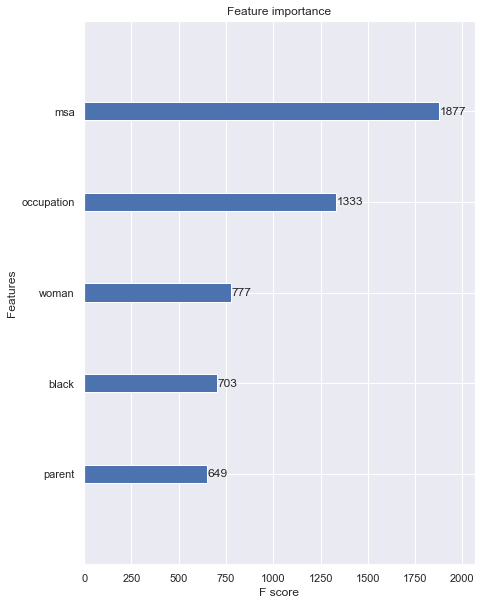

In [41]:
plt.rcParams["figure.figsize"] = (7, 10)
plot_importance(model)